# (3) SSA including time-dependent protein production rate

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Here we set up the SSA to be used for the parameter inference in the SMC ABC computations. The arguments are in order:
- 1. `S_time` The number of simulation trajectories to be performed.
- 2. `inf_params` The model parameters to be inferred chosen by the user/simulator function (time in units min$^{-1}$): $\{\alpha_0, \alpha_1, \beta_0, \beta_1, d\}$.
- 3. `spec_params` The model parameters specified by the experimental data: $\{V_0, n_0, \theta\}$.
- 4. `max_time` The time through which to run the simulation.

Other parameters include: $M$ = # reactions, $N$ = # species.

In [1]:
#include("./SSA_file.jl"); using .SSAmod;

function SSA(S_time::Int64, inf_params::Array{Float64,1}, spec_params::Array{Float64,1}, max_time::Int64)
    M = 2; N = 1; 
    α0 = inf_params[1]; α1 = inf_params[2]; β0 = inf_params[3]; β1 = inf_params[4]; d = inf_params[5]; 
    V0 = spec_params[1]; n0 = spec_params[2]; θ = spec_params[3];
    
    # Define stoichiometric matrix
    S_mat = zeros(M);
    S_mat[1] = +1; # the burst size is randomly chosen later.
    S_mat[2] = -1;
    
    sp = 1.0; # sampling period is same as experimental data.
    n = zeros(S_time,Int64(floor(max_time/sp))); # reaction state vector
    c = zeros(S_time,Int64(floor(max_time/sp))); # conc vector
    v = ones(S_time,Int64(floor(max_time/sp))); # volume vector
    
    """
    * This first loop is for if we decide to average over more than one lineage - sim = 1 by default.
    * It also defines some constants that will be needed for the sim.
    """
    for sim in 1:S_time
        n_temp = n0; # set the current state vec to appropriate molecule number at homeostasis.
        T = 0.0 ::Float64; # set the overall time

        # while loop choosing to stop the simulation once the maximum time is reached.
        while T <= max_time
            # incorporate the time dependent rate explicitly.

            # Step 1: Calculate tau chosen rection for time dep rate.
            r1,r2 = rand(1,2);
            a1 = α0*(V0*exp(θ*T))^α1; a2 = d*n_temp;
            if isinf(lambertw((a1/a2)*(r1^(-α1*θ/a2))*exp(a1/a2))) # (**) if value is infinite go again.
                # print(a1/a2, "\n", r1^(-α1/a2), "\n", exp(a1/a2),"\n")
                tau = 0.0; # set to zero by default if get error.
            elseif a2 > 0 # distinguish between a2=0 and a2>0 cases separately.
                # print("hi")
                tau = (1/(α1*θ*a2))*(a1+α1*θ*log(1/r1)-a2*lambertw((a1/a2)*(r1^(-α1*θ/a2))*exp(a1/a2)));
            else
                tau = (1/(α1*θ))*log(1+(α1*θ/a1)*log(1/r1));
            end
            tau_props = [(a1/(α1*θ))*(exp(α1*θ*tau)-1),tau*a2]; sum_props = sum(tau_props);
            next_r = findfirst(x -> x>=r2*sum_props,cumsum(tau_props));

            # Step 1.5: choose a burst size from geometric with mean b(t).
            b = β0*(V0*exp(θ*T))^β1;
            bs = rand(Geometric((1/b)/((1/b)+1))); # rand burst size.
            # print(b,"\t",bs,"\n")

            # Step 2: Update the system
            T += tau;
            if isnan((T-tau)/sp) # catch the numerical error from (**)
                print("error!", "\n", r1, "\n", α1/a2, "\n", r1^(-α1/a2), "\n", exp(a1/a2), "\n", exp(a1/a2), "\n", (a1/a2)*(r1^(-α1/a2))*exp(a1/a2), "\n","boom")
            end
            # Update the trajectory vector
            if T < max_time # checks that T hasen't exceeded cell-cycle time or total time.
                for t in Int(ceil((T-tau)/sp)) : Int(floor(T/sp))
                    n[sim,t+1] = n_temp;
                    c[sim,t+1] = n_temp/(V0*exp(θ*t)); # the (t*sp)-(T-tc) updates is the volume for that time indexed by t.
                    v[sim,t+1] = V0*exp(θ*t);
                end
                # Fire reaction next_r
                if next_r == 1
                    prod = bs*S_mat[next_r];
                elseif next_r == 2
                    prod = S_mat[next_r];
                else
                    println("error!")
                end
                n_temp = n_temp + prod;
            else # else the cell cycle time alone has been exceeded and do this
                for t in Int(ceil((T-tau)/sp)) : Int(floor(max_time/sp)-1)
                    n[sim,t+1] = n_temp;
                    c[sim,t+1] = n_temp/(V0*exp(θ*t));
                    v[sim,t+1] = V0*exp(θ*t);
                end
            end
        end
        #if mod(sim,100) == 0 # for multiple sims keep output after every 100.
        #    println(sim)
        end
    return n,c,v
end

SSA (generic function with 1 method)

This function has been saved as a module in a separate file so that we can import it to later bits of code for the SMC-ABC. Now, let's use this function for a sample set of parameters. First import the required functions.

In [2]:
using Distributions, LambertW;

Choose some values for the parameters and a reasonable number of time points.

In [9]:
# test code - Q: does sim fn work in here?
ssa = SSA(1, [3.083412069398955, 0.22670334072224252, 1.7273980241963505, 0.17574691423678512, 0.04813094645052603],[3.0,1.0,0.03], 30)

([1.0 4.0 … 174.0 192.0], [0.3333333333333333 1.2939273780646774 … 25.039210358886628 26.812899151848896], [3.0 3.091363601860551 … 6.949100930343274 7.160732560572829])

Let's plot the molecule number, concentrations and volume output from this SSA function.

In [4]:
using PyPlot;

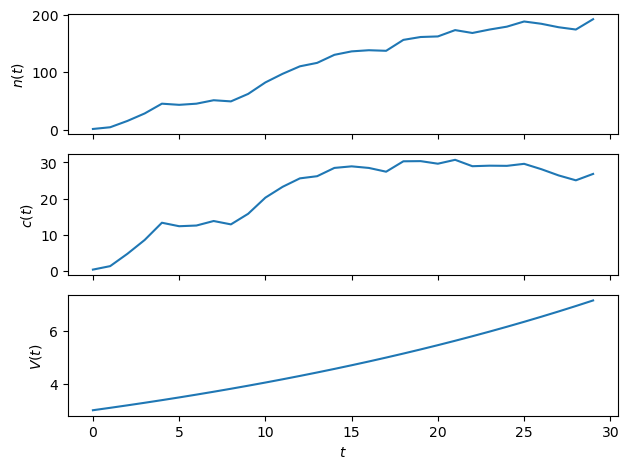

In [11]:
fig, axs = PyPlot.subplots(3, 1, sharex = true, tight_layout = true);
axs[3].set_xlabel(L"t"); axs[1].set_ylabel(L"n(t)"); axs[2].set_ylabel(L"c(t)"); axs[3].set_ylabel(L"V(t)");
axs[1].plot(range(0,length(ssa[1][:])-1,step=1),ssa[1][:]); axs[2].plot(range(0,length(ssa[2][:])-1,step=1),ssa[2][:]); axs[3].plot(range(0,length(ssa[3][:])-1,step=1),ssa[3][:]);

In [52]:
trunc(Int,1.008947894785785789745030)

1

In [2]:
rand(1)

1-element Array{Float64,1}:
 0.9169081367585965